In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

import torch
numpy = lambda x : x.detach().cpu().numpy().squeeze()
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
torch.__version__

import pyrtools as pt
import plenoptic as po

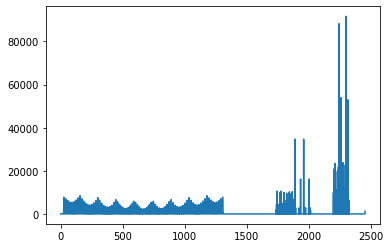

In [2]:
X = np.load('metamer_PS_samples.npy')

# calculate the normalization Factor from saved samples
sigma = X.std(axis=1)
sigma[sigma<.00001] = 1
normalizationFactor = 1 / sigma

plt.plot(normalizationFactor);

normalizationFactor = torch.diag(torch.tensor(normalizationFactor, dtype=torch.float32))

(-10, 10)

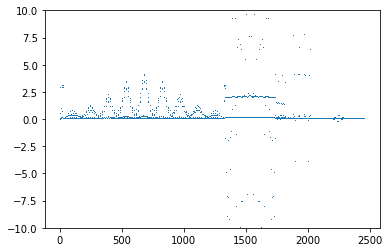

In [3]:
# TODO list these parameters that stay silent
mu = X.mean(axis=1)
plt.plot(mu, ',');
plt.ylim((-10,10))

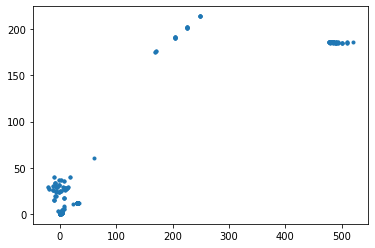

In [4]:
plt.plot(mu, sigma, '.')

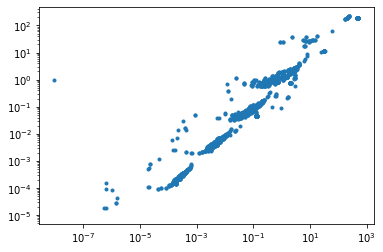

In [5]:
plt.loglog(mu, sigma, '.')

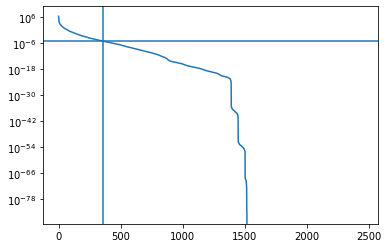

0.9999999999064094


torch.Size([355, 2456])

In [6]:
evals, evecs = np.linalg.eigh(np.cov(X))
evals = evals[::-1]
evecs = evecs[:,::-1]

epsilon = .00001 #1e-15
k = np.where(evals > epsilon)[0].max()

plt.semilogy(evals)
plt.axhline(epsilon)
plt.axvline(k)
plt.show()

print(evals[:k].sum() / evals.sum())

S = np.diag(1 / np.sqrt(evals[:k])) @ evecs[:, :k].T
S = torch.tensor(S, dtype=torch.float32)
S.shape

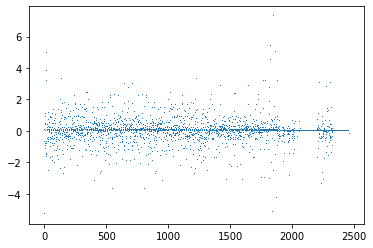

In [7]:
plt.plot(np.diag(evecs[:, :k]) @ numpy(S), ',');

In [9]:
model = po.simul.Texture_Statistics([256,256], normalizationFactor = normalizationFactor)

In [10]:
image = plt.imread('../data/nuts.pgm').astype(float)/255.
im0 = torch.tensor(image, requires_grad=True, dtype = torch.float32).squeeze().unsqueeze(0).unsqueeze(0)
# clamp pixels between 0,1
c = po.RangeClamper([image.min(), image.max()])
M = po.synth.Metamer(im0, model)

In [11]:
# test SGD
matched_image, matched_representation = M.synthesize(max_iter=300, learning_rate=1, seed=1,
                                                     fraction_removed=.05, clamper = c)

100%|██████████| 300/300 [04:13<00:00,  1.16it/s, gradient_norm=2.3562e-01, learning_rate=0.04, loss=3.0015e+00]


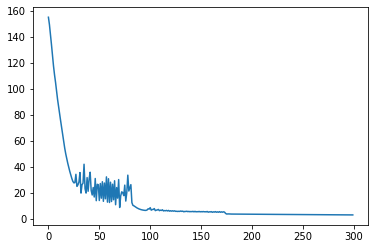

In [12]:
plt.plot(M.loss)

Difference statistics:
  Range: [0, 1]
  Mean: -0.004289,  Stdev (rmse): 0.494024,  SNR (dB): -2.722019

 model metric: 0.06046324968338013


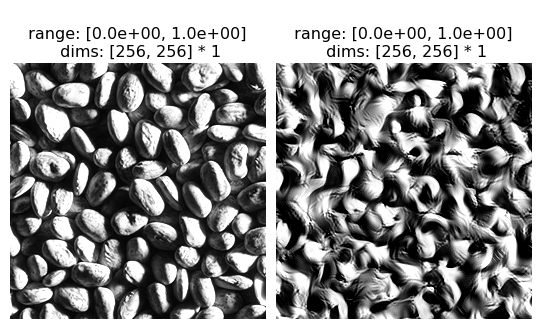

In [13]:
pt.imshow([image, numpy(M.matched_image)]);
pt.image_compare(image, numpy(M.matched_image))
m = po.metric.model_metric(M.target_image, M.matched_image, model).item()
print('\n model metric: ' + str(m))
